In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [5]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm 
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
train_file = pd.read_csv('/kaggle/input/titanic/train.csv')
test_file = pd.read_csv('/kaggle/input/titanic/test.csv')

In [7]:
train_file.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
y_train = train_file['Survived']
y_train = y_train.to_numpy()
test_id = test_file['PassengerId']

In [9]:
x_train = train_file.drop(['PassengerId','Survived','Name','Ticket','Fare','Cabin','Embarked','SibSp','Parch'], axis = 1)
test_file.drop(['PassengerId','Name','Ticket','Fare','Cabin','Embarked','SibSp','Parch'], axis = 1, inplace = True)

In [10]:
x_train.head()

,Pclass,Sex,Age
0,3,male,22.0
1,1,female,38.0
2,3,female,26.0
3,1,female,35.0
4,3,male,35.0


In [11]:
test_file.head()

,Pclass,Sex,Age
0,3,male,34.5
1,3,female,47.0
2,2,male,62.0
3,3,male,27.0
4,3,female,22.0


In [12]:
x_train["Age"].fillna(29, inplace = True)
test_file["Age"].fillna(29, inplace = True)

In [13]:
gender = {'male': 1,'female': 0}

In [14]:
x_train.Sex = [gender[item] for item in x_train.Sex]
test_file.Sex = [gender[item] for item in test_file.Sex]

In [15]:
np_x = x_train.values
np_test = test_file.values

In [16]:
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(np_x)
# test_scaled = min_max_scaler.fit_transform(np_test)

In [17]:
np_x_nor = preprocessing.normalize(np_x)

In [18]:
np_test_nor = preprocessing.normalize(np_test)

In [19]:
np_x_nor = np_x_nor.astype(np.float32)
np_test_nor = np_test_nor.astype(np.float32)

In [20]:
x_train, y_train, x_test = map(torch.tensor, (np_x_nor,y_train,np_test_nor))

In [21]:
len(x_train)

891

In [22]:
train_data = []
for i in range(len(x_train)):
   train_data.append([x_train[i], y_train[i]])
test_data = x_test

In [23]:
len(train_data)

891

In [24]:
bs = 64

In [67]:
trainloader = torch.utils.data.DataLoader(train_data,batch_size = bs, shuffle = True)
testloader = torch.utils.data.DataLoader(test_data, batch_size = bs)

In [26]:
14*64

896

In [27]:
dataiter = iter(trainloader)

In [28]:
data, label = dataiter.next()

In [29]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.classifier = nn.Sequential(
            nn.Linear(3,16),
            nn.Tanh(),
            nn.Linear(16,4),
            nn.Tanh(),
            nn.Linear(4,2),
            nn.Softmax()
            
        )
        
    def forward(self,x):
        return self.classifier(x)
        

In [30]:
class MyModelBN(nn.Module):
    def __init__(self): 
        super(MyModelBN, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(3, 16),
            nn.BatchNorm1d(16),
            nn.Tanh(),
            nn.Linear(16, 4),
            nn.BatchNorm1d(4),
            nn.Tanh(),
            nn.Linear(4, 2),
            nn.Softmax()
        )
             
    def forward(self,x):
        return self.classifier(x)

In [31]:
def fit(x,y, model, opt, loss_fn, epochs = 1000):
    
    for epoch in tqdm(range(epochs)):
        loss = loss_fn(model(x),y)
        print('Loss is ......',loss)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item()

In [57]:
fn = MyModel()
loss_fn = F.cross_entropy
opt = torch.optim.Adam(fn.parameters(), lr = 0.08)
fit(x_train, y_train, fn, opt, loss_fn)

Loss is ...... tensor(0.6785, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.6655, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.6680, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.6660, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.6658, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.6662, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.6649, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.6640, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.6633, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.6637, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.6631, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.6629, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.6622, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.6611, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.6605, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.6599, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.6594, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.6592, g

Loss is ...... tensor(0.5101, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5100, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5100, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5099, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5099, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5099, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5098, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5098, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5097, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5097, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5096, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5096, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5095, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5095, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5094, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5094, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5094, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5093, g

Loss is ...... tensor(0.5042, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5042, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5042, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5042, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5042, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5042, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5042, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5042, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5041, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5042, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5041, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5041, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5041, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5041, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5041, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5041, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5041, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5041, g

Loss is ...... tensor(0.5039, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5038, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5038, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5037, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5037, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5037, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5037, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5037, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5036, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5036, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5036, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5036, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5036, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5035, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5035, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5035, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5035, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5035, g

Loss is ...... tensor(0.5029, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5029, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5029, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5029, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5029, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5029, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5028, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5028, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5028, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5028, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5028, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5028, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5028, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5028, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5028, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5028, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5028, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5028, g

Loss is ...... tensor(0.5095, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5095, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5094, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5095, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5095, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5094, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5094, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5094, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5094, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5094, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5094, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5094, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5094, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5094, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5094, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5094, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5094, grad_fn=<NllLossBackward>)
Loss is ...... tensor(0.5094, g

0.5084596276283264

In [58]:
model = MyModel()
model_bn = MyModelBN()

In [59]:
opt_bn = torch.optim.Adam(model_bn.parameters(), lr=0.05)
opt = torch.optim.Adam(model.parameters(), lr = 0.05)


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


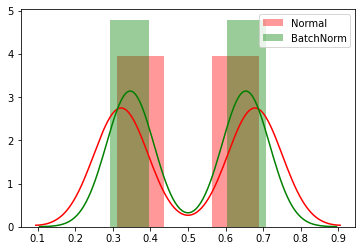

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


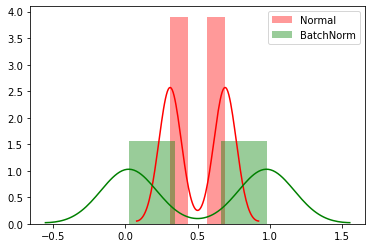

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


----------------------


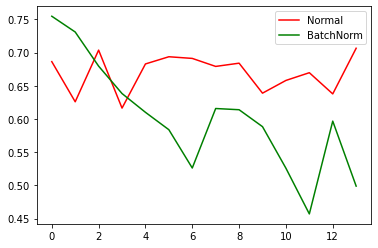

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


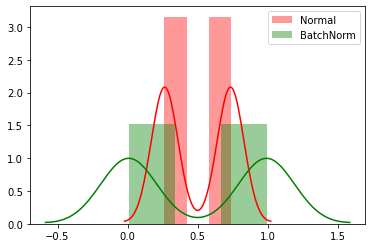

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


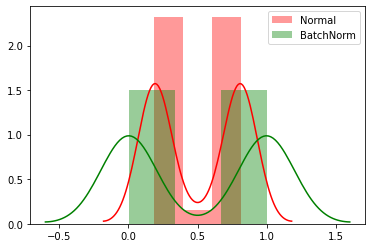

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


----------------------


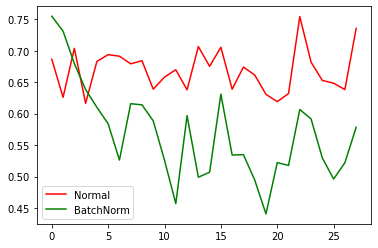

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


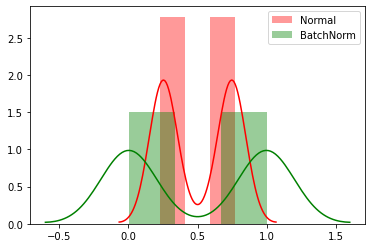

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


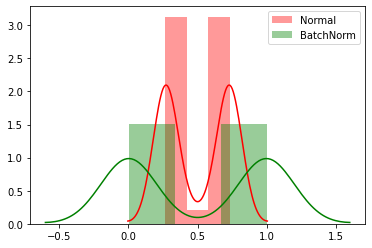

----------------------


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


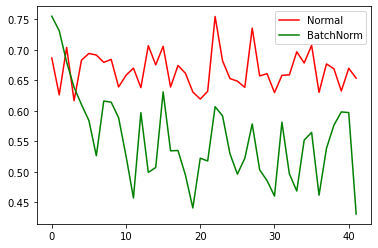

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


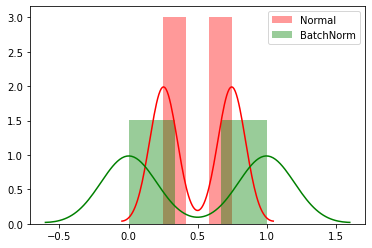

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


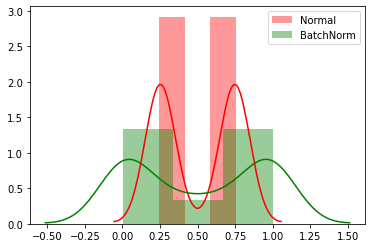

----------------------


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


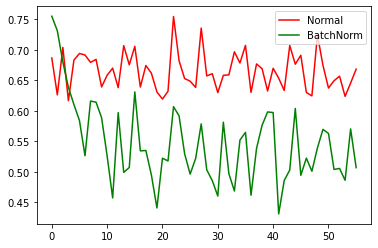

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


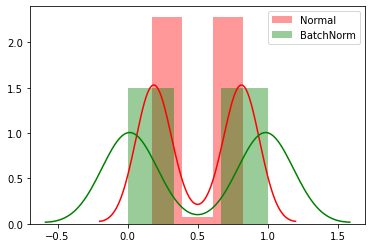

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


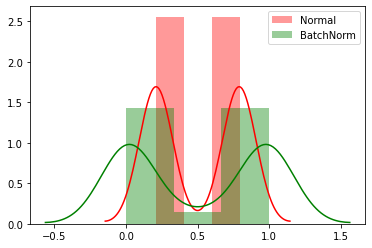

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


----------------------


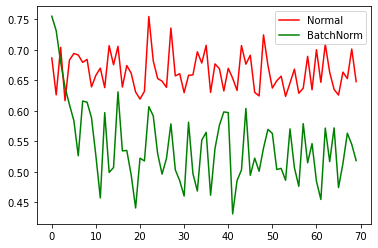

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


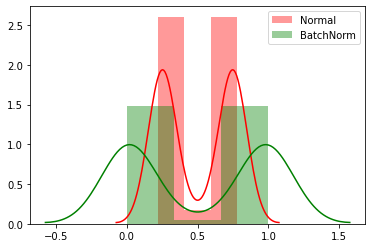

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


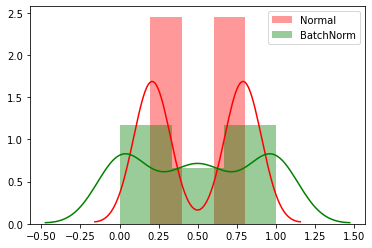

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


----------------------


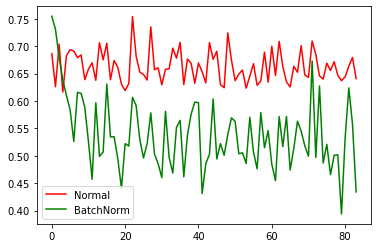

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


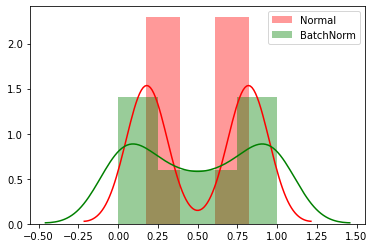

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


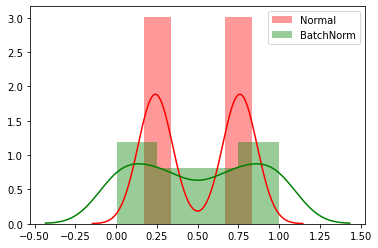

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


----------------------


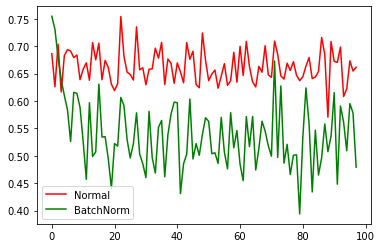

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


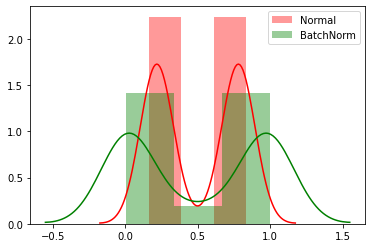

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


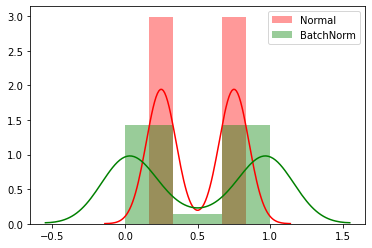

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


----------------------


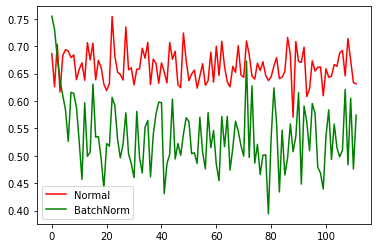

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


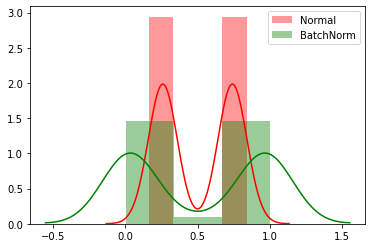

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


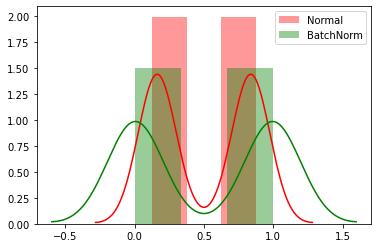

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


----------------------


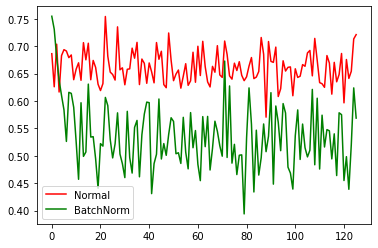

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


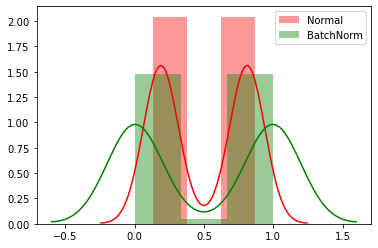

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


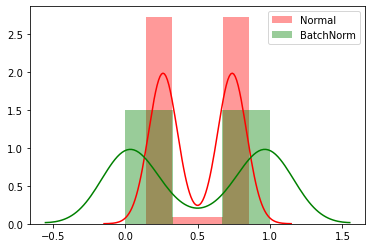

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


----------------------


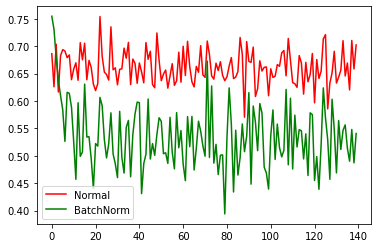

In [60]:
loss_arr = []
loss_bn_arr = []

max_epochs = 10

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        # training steps for normal model
        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        # training steps for bn model
        opt_bn.zero_grad()
        outputs_bn = model_bn(inputs)
        loss_bn = loss_fn(outputs_bn, labels)
        loss_bn.backward()
        opt_bn.step()
        
        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())
        
        if i % 10 == 0:
        
            inputs = inputs.view(inputs.size(0), -1)
            
            model.eval()
            model_bn.eval()
            
            a = model.classifier(inputs)
#             a = model.classifier[1](a)
#             a = model.classifier[2](a)
            a = a.detach().numpy().ravel()
            sns.distplot(a, kde=True, color='r', label='Normal') 
            
            b = model_bn.classifier(inputs)
#             b = model_bn.classifier[1](b)
#             b = model_bn.classifier[2](b)
#             b = model_bn.classifier[3](b)
#             b = model_bn.classifier[4](b)
            b = b.detach().numpy().ravel()
            
            sns.distplot(b, kde=True, color='g', label='BatchNorm') 
#             plt.title('%d: Loss = %0.2f, Loss with bn = %0.2f' % (i, loss.item()))
            plt.legend()
            plt.show()
            plt.pause(0.5)
            
            model.train()
            model_bn.train()
        
        
    print('----------------------')

    plt.plot(loss_arr, 'r', label='Normal')
    plt.plot(loss_bn_arr, 'g', label='BatchNorm')
    plt.legend()
    plt.show()

In [61]:
def train_evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs, labels
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [62]:
def test_evaluation(dataloader, model):
    mypred = []
    out = []
    for data in dataloader:
        inputs = data
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        mypred.append(pred.detach().numpy())
        for arr in mypred:
            for val in arr:
                out.append(val)
    return out

In [63]:
print(train_evaluation(trainloader,model_bn),train_evaluation(trainloader,model))

78.11447811447812 63.41189674523008


In [68]:
import csv

outpath = 'output.csv'

with open(outpath,'w', newline = '') as f:
    thewriter = csv.writer(f)
    thewriter.writerow(['PassengerId','Survived'])
    for index, val in zip(test_id.values.tolist(),test_evaluation(testloader, model_bn)):
        thewriter.writerow([index,val])

f.close()

In [41]:
ls

__notebook_source__.ipynb  output.csv


In [72]:
out1 = pd.read_csv('output.csv')

In [70]:
out1 = pd.read_csv('../input/titanic/gender_submission.csv')

In [73]:
out1.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
